Descarga imágenes Sentinel-2 con la librería SentinelHub de Python
==============


## Librería SentinelHub

SentinelHub es una plataforma SIG (Sistema de Información Geográfica) basada en la nube para la distribución, gestión y análisis de imágenes satelitales.
Podemos acceder a los servicios de SentinelHub a través de la librería sentinelhub de Python.

### Iniciar sesión

En primer lugar, cargamos las librerías que vamos a utilizar y configuramos las credenciales de la API.

In [1]:
from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    WmsRequest,
    CustomUrlParam
)
import datetime
import matplotlib.pyplot as plt
import numpy as np

config = SHConfig()
config.instance_id = '70265a40-8c2b-4751-86d9-217b24acd2e6'
config.sh_client_id = 'ef80979a-159a-4758-8cfc-8034ec77943f'
config.sh_client_secret = 'ZF,95^NS[l5w+Hf3FbJ_}HcMWduP&bFzDekDhXt_'

c:\ProgramData\Miniconda3\envs\geo_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Definir región y tiempo de interés

Generamos un BoundingBox para delimitar la zona de interés. Para ello, creamos la clase BoundingBox formada por un objeto BBox propio de SentinelHub y por las dimensiones de dicho objeto.
Creamos una nueva instancia de la clase mediante las coordenadas geográficas de dos puntos (esquina superior izquierda e inferior derecha) del BoundingBox, el Sistema de Referencia de Coordenadas (CRS) y la resolución espacial de la imagen.
También definimos el rango de fechas en el que queremos realizar la búsqueda.

In [ ]:
class BoundingBox():
   def __init__(self, coords, crs, resolution):
    self.bbox = BBox(bbox = coords, crs = crs)
    self.size = bbox_to_dimensions(bbox = self.bbox, resolution = resolution)

bbox = BoundingBox([-1.98, 42.54, -1.97, 42.53], CRS.WGS84, resolution = 10)
date_range = ("2022-07-01","2022-07-30")

### Búsqueda de imágenes 

Además de la región y tiempo de interés, para realizar la búsqueda de las imágenes, es necesario crear un script de evaluación de las bandas espectrales. 
En nuestro caso, queremos obtener el color natural, por lo tanto, trabajamos sólo con las bandas rojo, verde y azul.

In [ ]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

Con todo ya definido, podemos proceder a la búsqueda de las imágenes, creando una lista de peticiones a la API de SentinelHub.

In [ ]:
def CreateSentinelRequest(evalscript: str, time_interval: tuple, bb: BoundingBox):
    request = SentinelHubRequest(
        evalscript = evalscript,
        input_data = [
            SentinelHubRequest.input_data(
                data_collection = DataCollection.SENTINEL2_L1C,
                time_interval = time_interval,
            )
        ],
        responses = [
            SentinelHubRequest.output_response("default", MimeType.PNG),
        ],
        bbox = bb.bbox,
        size = bb.size,
        config = config,
    )
    return request

def GetSentinelRequest(evalscript: str, slots: list, bounding_box: BoundingBox):    

    # create a list of requests
    list_of_requests = [CreateSentinelRequest(evalscript, slot, bounding_box) for slot in slots]
    list_of_requests = [request.download_list[0] for request in list_of_requests]

    return list_of_requests

requests = GetSentinelRequest (
    script = evalscript_true_color,
    dates = date_range,
    bounding_box = bbox
)

### Descarga de imágenes

Efectuamos las peticiones a través de múltiples hilos a partir del listado de peticiones obtenido anteriormente.

In [ ]:
def GetSentinelImages(list_of_requests: list):    
    # download data with multiple threads
    images = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)
    return images

images = GetSentinelImages(requests)

### Mostrar imágenes descargadas


In [ ]:
def ShowImages(images, slots, bbox_size):
    
    ncols = 4
    nrows = 3
    aspect_ratio = bbox_size[0] / bbox_size[1]
    subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

    for idx, image in enumerate(images):
        ax = axs[idx // ncols][idx % ncols]
        ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
        ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

    plt.tight_layout()

ShowImages(images)

Existe una forma directa de descargar de las imágenes. Hacemos la prueba de descargar imágenes recientes del cauce del río Ebro a su paso por Tudela.

In [19]:
tudela_coords = [-1.61, 42.07, -1.58, 42.05]
tudela_bbox = BoundingBox(tudela_coords, CRS.WGS84, 10)

wms_request = WmsRequest(
    data_collection = DataCollection.SENTINEL2_L1C,
    layer = "NATURAL-COLOR",
    bbox = tudela_bbox.bbox,
    time = "latest",
    width = tudela_bbox.size[0],
    height = tudela_bbox.size[1],
    custom_url_params = {CustomUrlParam.SHOWLOGO: False},
    image_format = MimeType.PNG,
    config = config
)

print(wms_request.get_url_list())
wms_img = wms_request.get_data()

['https://services.sentinel-hub.com/ogc/wms/70265a40-8c2b-4751-86d9-217b24acd2e6?SERVICE=wms&WARNINGS=False&MAXCC=100.0&ShowLogo=False&BBOX=42.05%2C-1.61%2C42.07%2C-1.58&FORMAT=image%2Fpng&CRS=EPSG%3A4326&TIME=2022-07-07T11%3A09%3A35Z%2F2022-07-07T11%3A09%3A35Z&WIDTH=245&HEIGHT=226&LAYERS=NATURAL-COLOR&REQUEST=GetMap&VERSION=1.3.0']


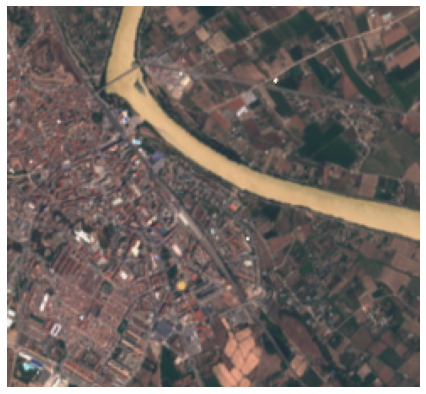

In [23]:
from PIL import Image
im = Image.fromarray(wms_img[-1])
im.save("C:/i3/EMERAL/Sentinel/savedimage.png")

def plot_image(image, factor=1):
    plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)
        
plot_image(wms_img[-1])
